## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

 - This Notebook aims to compute the MOC upper branch in the 34.5oS (SAMBAR) and compare the results with the observations. The upper branch is the integrated volume transport from the surface to the level where the meridional volume transport inverts.

## Imports

In [1]:
import xarray as xr
import pandas as pd
import numpy as np  
import dask
import cf_xarray
import intake
import cftime
import nc_time_axis
import intake_esm
import matplotlib.pyplot as plt
import pop_tools
from dask.distributed import Client
from ncar_jobqueue import NCARCluster
import warnings, getpass, os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import cumtrapz
from scipy import integrate

## Dask

In [2]:
mem_per_worker = 20 # memory per worker in GB 
num_workers = 60 # number of workers
cluster = NCARCluster(cores=1, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.55:43665' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:43665,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in OGCM history file & MOC template file

In [3]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

/glade/u/home/mauricio/.local/lib/python3.8/site-packages/intake_esm/utils.py:96: DtypeWarning: Columns (5,6,9) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(catalog_path, **csv_kwargs), catalog_path


In [4]:
cat_subset = catalog.search(component='ocn',variable=['MOC'],frequency='month_1',experiment="historical")

In [5]:
# Load catalog entries for subset into a dictionary of xarray datasets
dset_dict_raw  = cat_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dset_dict_raw.keys()}")


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'



Dataset dictionary keys:
 dict_keys(['ocn.historical.pop.h.cmip6.MOC', 'ocn.historical.pop.h.smbb.MOC'])


In [6]:
%%time
fb=('cmip6','smbb')
for ifb in range(0,2):  
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.historical.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'1850-01-01\', \'2014-12-31\'))' # Time Series
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.resample(time=\'1Y\', closed=\'left\').mean(\'time\')' # Yearly average
    exec(str)
    str=f'moc_{fb[ifb]} = ds_{fb[ifb]}_moc[\'MOC\']' # Variable
    exec(str)
    str=f'del ds_{fb[ifb]}_moc'
    exec(str)

Forcing_variant: 0
Forcing_variant: 1
CPU times: user 10 s, sys: 113 ms, total: 10.1 s
Wall time: 10.4 s


In [7]:
%%time
for ifb in range(0,2): 
    print(f"Forcing_variant: {ifb}")
    str=f'moc_{fb[ifb]}[\'moc_z\'] = -0.01*moc_{fb[ifb]}.moc_z' # cm to m and negative depth
    print(str)
    exec(str) 
    str=f'zz_{fb[ifb]}, yy_{fb[ifb]} = np.meshgrid(moc_{fb[ifb]}.moc_z, moc_{fb[ifb]}.lat_aux_grid)'
    print(str)
    exec(str) 
    str=f'zz_{fb[ifb]}=(np.array([zz_{fb[ifb]}]*len(moc_{fb[ifb]}[\'member_id\']))).transpose(0,2,1)'
    print(str)
    exec(str)
    str=f'yy_{fb[ifb]}=(np.array([yy_{fb[ifb]}]*len(moc_{fb[ifb]}[\'member_id\']))).transpose(0,2,1)'
    print(str)
    exec(str)

Forcing_variant: 0
moc_cmip6['moc_z'] = -0.01*moc_cmip6.moc_z
zz_cmip6, yy_cmip6 = np.meshgrid(moc_cmip6.moc_z, moc_cmip6.lat_aux_grid)
zz_cmip6=(np.array([zz_cmip6]*len(moc_cmip6['member_id']))).transpose(0,2,1)
yy_cmip6=(np.array([yy_cmip6]*len(moc_cmip6['member_id']))).transpose(0,2,1)
Forcing_variant: 1
moc_smbb['moc_z'] = -0.01*moc_smbb.moc_z
zz_smbb, yy_smbb = np.meshgrid(moc_smbb.moc_z, moc_smbb.lat_aux_grid)
zz_smbb=(np.array([zz_smbb]*len(moc_smbb['member_id']))).transpose(0,2,1)
yy_smbb=(np.array([yy_smbb]*len(moc_smbb['member_id']))).transpose(0,2,1)
CPU times: user 11.1 ms, sys: 1.99 ms, total: 13.1 ms
Wall time: 16.2 ms


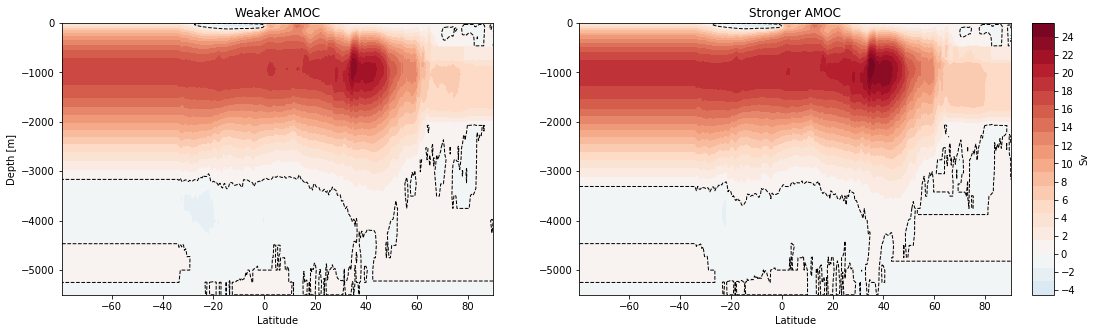

In [8]:
str=f'Z1 = moc_{fb[1]}.isel(transport_reg=1, moc_comp=0).sel(time=slice(\'1900-01-01\',\'1920-01-01\')).mean(dim=[\'member_id\',\'time\'])'
exec(str)
str=f'Z2 = moc_{fb[1]}.isel(transport_reg=1, moc_comp=0).sel(time=slice(\'1985-01-01\',\'2005-01-01\')).mean(dim=[\'member_id\',\'time\'])'
exec(str)
str=f'X, Y = np.meshgrid(moc_{fb[1]}[\'lat_aux_grid\'],moc_{fb[1]}[\'moc_z\'])'
exec(str)
mn=-26
mx=26
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[17, 5])

im1 = ax1.contourf(X, Y, Z1, 20, vmin=mn, vmax=mx, cmap="RdBu_r")

axins = inset_axes(ax2,
                   width="5%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax2.transAxes,
                   borderpad=0,
                   )
im = ax2.contourf(X, Y, Z2, 20, vmin=mn, vmax=mx, cmap="RdBu_r")
fig.colorbar(im, cax=axins, ticks=range(mn, mx, 2),label='Sv')
ax1.contour(X, Y, Z1, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax2.contour(X, Y, Z2, levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax1.set_title('Weaker AMOC')
ax2.set_title('Stronger AMOC')
ax1.set_xlabel('Latitude')
ax2.set_xlabel('Latitude')
ax1.set_ylabel('Depth [m]')
plt.show()

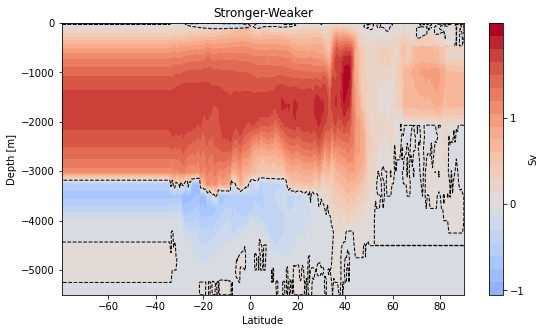

In [9]:
# Plot
fig, (ax3) = plt.subplots(figsize=(9, 5)) 
cs1 = ax3.contourf(X, Y, abs(Z2)-abs(Z1), 20, vmin=-2, vmax=2, cmap="coolwarm")
ax3.contour(X, Y, abs(Z2)-abs(Z1), levels = [0], colors=('k',), linestyles=('--',), linewidths=(1,))
ax3.set_title('Stronger-Weaker')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Depth [m]') 
plt.colorbar(cs1,ticks=range(-2, 2),label='Sv')
plt.show()

In [10]:
%%time
fb=('cmip6','smbb')
for ifb in range(0,2):  
    print(f"Forcing_variant: {ifb}")
    str=f'ds_{fb[ifb]}_moc = dset_dict_raw[\'ocn.historical.pop.h.{fb[ifb]}.MOC\']' 
    exec(str)
    str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.sel(time=slice(\'2009-01-01\', \'2014-12-31\'))' # Time Series
    exec(str)
    #str=f'ds_{fb[ifb]}_moc = ds_{fb[ifb]}_moc.resample(time=\'1Y\', closed=\'left\').mean(\'time\')' # Yearly average
    #exec(str)
    str=f'moc_{fb[ifb]} = ds_{fb[ifb]}_moc[\'MOC\']' # Variable
    exec(str)
    str=f'del ds_{fb[ifb]}_moc'
    exec(str)
for ifb in range(0,2): 
    print(f"Forcing_variant: {ifb}")
    str=f'moc_{fb[ifb]}[\'moc_z\'] = -0.01*moc_{fb[ifb]}.moc_z' # cm to m and negative depth
    print(str)
    exec(str) 
    str=f'zz_{fb[ifb]}, yy_{fb[ifb]} = np.meshgrid(moc_{fb[ifb]}.moc_z, moc_{fb[ifb]}.lat_aux_grid)'
    print(str)
    exec(str) 
    str=f'zz_{fb[ifb]}=(np.array([zz_{fb[ifb]}]*len(moc_{fb[ifb]}[\'member_id\']))).transpose(0,2,1)'
    print(str)
    exec(str)
    str=f'yy_{fb[ifb]}=(np.array([yy_{fb[ifb]}]*len(moc_{fb[ifb]}[\'member_id\']))).transpose(0,2,1)'
    print(str)
    exec(str)

Forcing_variant: 0
Forcing_variant: 1
Forcing_variant: 0
moc_cmip6['moc_z'] = -0.01*moc_cmip6.moc_z
zz_cmip6, yy_cmip6 = np.meshgrid(moc_cmip6.moc_z, moc_cmip6.lat_aux_grid)
zz_cmip6=(np.array([zz_cmip6]*len(moc_cmip6['member_id']))).transpose(0,2,1)
yy_cmip6=(np.array([yy_cmip6]*len(moc_cmip6['member_id']))).transpose(0,2,1)
Forcing_variant: 1
moc_smbb['moc_z'] = -0.01*moc_smbb.moc_z
zz_smbb, yy_smbb = np.meshgrid(moc_smbb.moc_z, moc_smbb.lat_aux_grid)
zz_smbb=(np.array([zz_smbb]*len(moc_smbb['member_id']))).transpose(0,2,1)
yy_smbb=(np.array([yy_smbb]*len(moc_smbb['member_id']))).transpose(0,2,1)
CPU times: user 46.5 ms, sys: 981 µs, total: 47.5 ms
Wall time: 54.6 ms


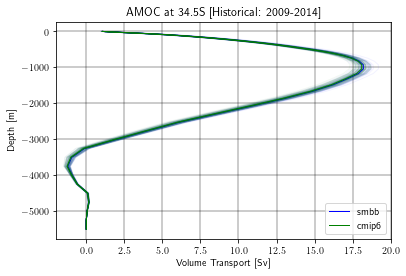

In [11]:
plt.rcParams['text.usetex'] = True
moc_mean=moc_smbb.isel(transport_reg=1,moc_comp=0).where((moc_smbb.isel(transport_reg=1,moc_comp=0)['lat_aux_grid']>-34.7) & (moc_smbb.isel(transport_reg=1,moc_comp=0)['lat_aux_grid']<-34.3), drop=True).mean(['lat_aux_grid','time'])
moc_mean.plot.line(y="moc_z",color='blue',alpha=0.05,linewidth=1,add_legend=False)
moc_mean.mean(dim='member_id').plot.line(y="moc_z",color='blue',linewidth=1,label='smbb')
moc_mean=moc_cmip6.isel(transport_reg=1,moc_comp=0).where((moc_cmip6.isel(transport_reg=1,moc_comp=0)['lat_aux_grid']>-34.7) & (moc_cmip6.isel(transport_reg=1,moc_comp=0)['lat_aux_grid']<-34.3), drop=True).mean(['lat_aux_grid','time'])
moc_mean.plot.line(y="moc_z",color='green',alpha=0.05,linewidth=1,add_legend=False)
moc_mean.mean(dim='member_id').plot.line(y="moc_z",color='green',linewidth=1,label='cmip6')
plt.xlabel("Volume Transport [Sv]")
plt.ylabel("Depth [m]")
plt.title("AMOC at 34.5S [Historical: 2009-2014]")
plt.grid(color='k', linestyle='-', linewidth=0.4)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
#plt.text(19, -250, "A", ha="center", va="center", size=20,bbox=bbox_props)
plt.xlim(-2, 20)
plt.legend()
plt.show()

In [15]:
%%time
#e should process the entire dataset once we fix the issue with Dask. 
y_int = np.empty((len(moc_smbb['time']),len(moc_smbb['member_id']),2)) * np.nan
for ifb in range(0,1): # forcing variant (cmip6=0, smbb=1)
    print(f"Forcing_variant: {ifb}")
    for it in range(0,len(moc_smbb['time'])): # time 
        print(f"Time: {it}") 
        # AMOC for the 34.5S
        str=f'''amoc = moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0).where(
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] > -34.7) &
        (moc_{fb[ifb]}.isel(time=it,transport_reg=1,moc_comp=0)['lat_aux_grid'] < -34.3),
        drop=True
        ).mean(\'lat_aux_grid\')'''
        exec(str)
        for im in range(0,len(moc_smbb['member_id'])): # members (50 member in total)
            #print(f"Member: {im}")
            L = np.where(amoc.isel(member_id=im,moc_z=slice(46,61))<0) # 40=-1041.3682m; 60=-5499.9907m
            if len(amoc['moc_z'][L])==0: # If there is no negative transport in this interval (moc_z=slice(46,61)), the integral is done from surface to bottom. 
                y_int[it,im,ifb]=sum(amoc.isel(member_id=im,moc_z=slice(0,-1))*(amoc.isel(member_id=im)['moc_z'][0:-1].diff("moc_z")))/sum(amoc.isel(member_id=im)['moc_z'][0:-1].diff("moc_z"))
            else:
                y_int[it,im,ifb]=sum(amoc.isel(member_id=im,moc_z=slice(0,L[0][0]-1+46))*(amoc.isel(member_id=im)['moc_z'][0:L[0][0]-1+46].diff('moc_z')))/sum(amoc.isel(member_id=im)['moc_z'][0:L[0][0]-1+46].diff("moc_z"))

<timed exec>:2: RuntimeWarning: invalid value encountered in multiply


Forcing_variant: 0
Time: 0
Time: 1
Time: 2
Time: 3
Time: 4
Time: 5
Time: 6
Time: 7
Time: 8
Time: 9
Time: 10
Time: 11
Time: 12
Time: 13
Time: 14
Time: 15
Time: 16
Time: 17
Time: 18
Time: 19
Time: 20
Time: 21
Time: 22
Time: 23
Time: 24
Time: 25
Time: 26
Time: 27
Time: 28
Time: 29
Time: 30
Time: 31
Time: 32
Time: 33
Time: 34
Time: 35
Time: 36
Time: 37
Time: 38
Time: 39
Time: 40
Time: 41
Time: 42
Time: 43
Time: 44
Time: 45
Time: 46
Time: 47
Time: 48
Time: 49
Time: 50
Time: 51
Time: 52
Time: 53
Time: 54
Time: 55
Time: 56
Time: 57
Time: 58
Time: 59
Time: 60
Time: 61
Time: 62
Time: 63
Time: 64
Time: 65
Time: 66
Time: 67
Time: 68
Time: 69
Time: 70
Time: 71
CPU times: user 25min 35s, sys: 21.2 s, total: 25min 56s
Wall time: 53min 34s


In [16]:
samoc_upper_branch_lens2 = xr.Dataset({"MOC_up": (("time","member_id","forcing_variant"), y_int)},
                                coords={
                                    "time": moc_cmip6.coords['time'], 
                                    "member_id": moc_cmip6.coords['member_id'],
                                    "forcing_variant": ['cmip6 (0)','smbb (1)'],
                                    "transport_reg": [1],
                                    "moc_comp": [0],
                                    "experiment": ['historical'],
                                },
                                attrs={'description': 'Altantic Meridional Overturning Circulation (AMOC [Sv]) upper branch from the surface to the level where the transport volume reverses sign for the period from 2009 to 2014 (the period where there is a match between the SAMOC observation and LENS2 historical ), made by Mauricio Rocha (mauricio.rocha@usp.br)'},
                                     )
samoc_upper_branch_lens2["time"] = samoc_upper_branch_lens2["time"].astype("datetime64[ns]")

In [17]:
# create a directory on scratch to save the output
path = '/glade/scratch/mauricio/LENS2_south_atlantic/AMOC/'.format(getpass.getuser())
os.system('mkdir -p '+path)
samoc_upper_branch_lens2.to_netcdf(path+'_stats.nc')

In [18]:
import scipy.io
samoc_obs=scipy.io.loadmat('/glade/scratch/mauricio/SAMOC/Data/moc_sambar.mat')
samoc_moc=samoc_obs['moc'][:,0]
samoc_jd=samoc_obs['jd']-719529
timexr = pd.date_range("2009-03-18", periods=len(samoc_jd))
reference_time = pd.Timestamp("2009-03-17")
ds = xr.Dataset({'SAMOC': xr.DataArray(data=samoc_moc,dims=['time'],coords = {'time': timexr})})
ds_mean=ds.sel(time=slice('2009-03-18','2014-12-31')).resample(time='1M').mean('time')
ds_mean['time'] = samoc_upper_branch_lens2['time'][2:]

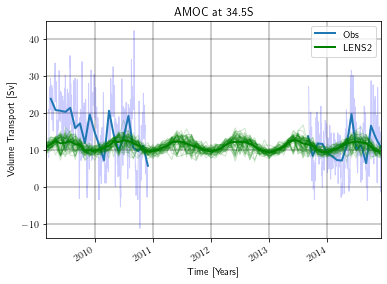

Obs Mean: 13.4
LENS2 Mean: 11.1
RMSE: 5.2


In [19]:
ds.SAMOC.sel(time=slice('2009-03-18','2014-12-31')).plot.line(x='time',color='blue',alpha=0.2,linewidth=1,add_legend=False)
ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')).plot.line(x='time',linewidth=2,label='Obs')
samoc_upper_branch_lens2.MOC_up.sel(time=slice('2009-03-01','2014-12-01')).mean(dim='forcing_variant').plot.line(x="time",color='green',alpha=0.2,linewidth=1,add_legend=False)
samoc_upper_branch_lens2.MOC_up.sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['member_id','forcing_variant']).plot.line(x="time",color='green',linewidth=2,label='LENS2')
plt.ylabel("Volume Transport [Sv]")
plt.xlabel("Time [Years]")
plt.title("AMOC at 34.5S")
plt.grid(color='k', linestyle='-', linewidth=0.4)
plt.xlim(ds_mean['time'][0], ds_mean['time'][-1])
#plt.ylim(5,25)
plt.legend()
plt.show()
obs_mean=mean=np.nanmean(ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))
LENS2_mean=np.nanmean(samoc_upper_branch_lens2.MOC_up.sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['member_id','forcing_variant']))
RMSE=((samoc_upper_branch_lens2.MOC_up.sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['member_id','forcing_variant'])-ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))**2).mean()**0.5
print(f"Obs Mean: {np.round(obs_mean,1)}")
print(f"LENS2 Mean: {np.round(LENS2_mean,1)}")
print(f"RMSE: {np.round(RMSE,1)}")

### Let's compute the mean square error for each member and evaluate which member came closest to the observation (the smallest error)

In [20]:
samoc_upper_branch_lens2.MOC_up.coords['member_id'][0].values

array('r10i1181p1f1', dtype='<U12')

In [21]:
for im in range(0,50): # members (50 member in total)
    RMSE_=((samoc_upper_branch_lens2.MOC_up.isel(member_id=im).sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['forcing_variant'])-ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))**2).mean()**0.5
    print(f"{samoc_upper_branch_lens2.MOC_up.coords['member_id'][im].values} RMSE: {np.round(RMSE,1)}")

r10i1181p1f1 RMSE: 5.2
r10i1231p1f1 RMSE: 5.2
r10i1251p1f1 RMSE: 5.2
r10i1281p1f1 RMSE: 5.2
r10i1301p1f1 RMSE: 5.2
r1i1001p1f1 RMSE: 5.2
r1i1231p1f1 RMSE: 5.2
r1i1251p1f1 RMSE: 5.2
r1i1281p1f1 RMSE: 5.2
r1i1301p1f1 RMSE: 5.2
r2i1021p1f1 RMSE: 5.2
r2i1231p1f1 RMSE: 5.2
r2i1251p1f1 RMSE: 5.2
r2i1281p1f1 RMSE: 5.2
r2i1301p1f1 RMSE: 5.2
r3i1041p1f1 RMSE: 5.2
r3i1231p1f1 RMSE: 5.2
r3i1251p1f1 RMSE: 5.2
r3i1281p1f1 RMSE: 5.2
r3i1301p1f1 RMSE: 5.2
r4i1061p1f1 RMSE: 5.2
r4i1231p1f1 RMSE: 5.2
r4i1251p1f1 RMSE: 5.2
r4i1281p1f1 RMSE: 5.2
r4i1301p1f1 RMSE: 5.2
r5i1081p1f1 RMSE: 5.2
r5i1231p1f1 RMSE: 5.2
r5i1251p1f1 RMSE: 5.2
r5i1281p1f1 RMSE: 5.2
r5i1301p1f1 RMSE: 5.2
r6i1101p1f1 RMSE: 5.2
r6i1231p1f1 RMSE: 5.2
r6i1251p1f1 RMSE: 5.2
r6i1281p1f1 RMSE: 5.2
r6i1301p1f1 RMSE: 5.2
r7i1121p1f1 RMSE: 5.2
r7i1231p1f1 RMSE: 5.2
r7i1251p1f1 RMSE: 5.2
r7i1281p1f1 RMSE: 5.2
r7i1301p1f1 RMSE: 5.2
r8i1141p1f1 RMSE: 5.2
r8i1231p1f1 RMSE: 5.2
r8i1251p1f1 RMSE: 5.2
r8i1281p1f1 RMSE: 5.2
r8i1301p1f1 RMSE: 5.2
r9i11

<function matplotlib.pyplot.show(close=None, block=None)>

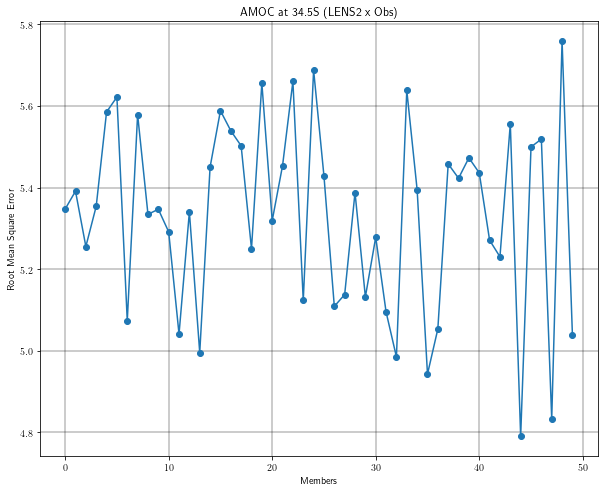

In [22]:
RMSE = np.empty((len(moc_smbb['member_id']))) * np.nan
for im in range(0,50): # members (50 member in total)
    RMSE[im]=((samoc_upper_branch_lens2.MOC_up.isel(member_id=im).sel(time=slice('2009-03-01','2014-12-01')).mean(dim=['forcing_variant'])-ds_mean.SAMOC.sel(time=slice('2009-03-18','2014-12-31')))**2).mean()**0.5
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(RMSE,'-o')
ax.set_ylabel("Root Mean Square Error")
ax.set_xlabel("Members")
ax.set_title("AMOC at 34.5S (LENS2 x Obs)")
ax.grid(color='k', linestyle='-', linewidth=0.4)
plt.show